# Getting started

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Three types of data are required to fit a ReMeta model:

<!---  Table --->
| Variable     |Description
|--------------|----------|
| `stimuli`    | list/array of signed stimulus intensity values, where the sign codes the stimulus category and the absolute value codes the intensity.       |
| `choices`    | list/array of choices coded as 0 (or alternatively -1) for the negative stimuli category and 1 for the positive stimulus category.         |
| `confidence` | list/array of confidence ratings. Confidence ratings must be normalized to [0; 1]. Discrete confidence ratings must be normalized accordingly (e.g., if confidence ratings are 1-4, subtract 1 and divide by 3).         |

When fitting individual participants, these are 1d lists / arrays with length `n_trials`. If 2d lists / arrays are passed, ReMeta treats this as group data with shape `n_subjects` x `n_trials` (-> Group data).

## A simple example

To quickly demonstrate ReMeta, we load a simple build-in dataset as follows.

In [7]:
import remeta
ds = remeta.load_dataset('default')

----------------------------------
..Generative model:
    Type 2 noise type: noisy_report
    Type 2 noise distribution: truncated_norm_mode
..Generative parameters:
    type1_noise: 0.5
    type1_bias: -0.1
    type2_noise: 0.3
    type2_criteria: [0.25 0.5  0.75]
        [extra] Criterion bias: 0
        [extra] Criterion absolute deviation: 0
..Descriptive statistics:
    No. subjects: 1
    No. samples: 2000
    Performance: 86.5% correct
    Choice bias: -3.1%
    Confidence: 0.61
    M-Ratio: 0.57
    AUROC2: 0.68
----------------------------------


The output provides information how the dataset was generated and some descriptive statistics.

The dataset was generated with four stimulus intensities. The psychometric function below shows that the observer performed at around 60% correct for the lowest (and most difficult) stimulus intensity and close to perfect for the highest intensity.

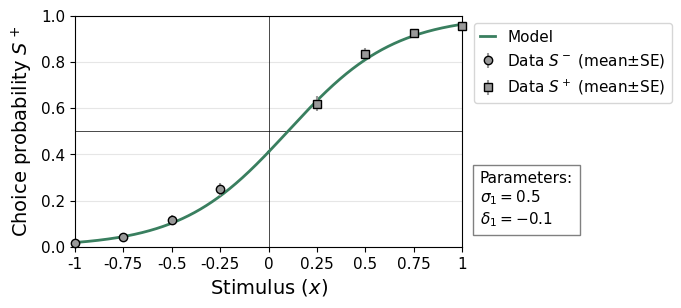

In [8]:
remeta.plot_psychometric(ds)


The relationship between stimulus intensity and confidence likewise reflects the bias, but also shows that the observer is less sensitive than predicted by a model without metacognitive noise. In the above descriptive statistics is visible from the low M-Ratio of 0.58.

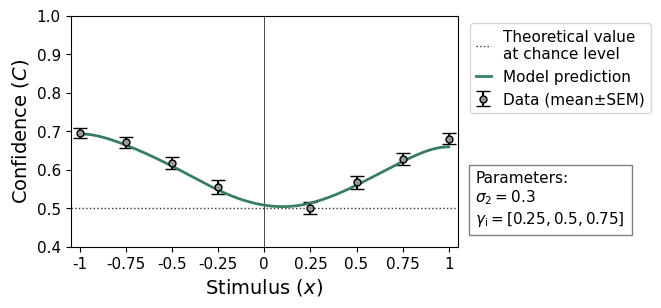

In [9]:
remeta.plot_stimulus_versus_confidence(ds, model_prediction=True)

In a next step, we fit the model. Since the data were generated with the default ReMeta model, we do not need to define any other settings. We pass the Configuration option `optim_type2_gridsearch=False` to the ReMeta instance though, to speed up this demo.

In [10]:
rem = remeta.ReMeta(optim_type2_gridsearch=False)
rem.fit(ds.stimuli, ds.choices, ds.confidence)


+++ Type 1 level +++
  Subject-level estimation (MLE)
    .. finished (0.1 secs).
  Final report
    Parameters estimates (subject-level fit)
        [subject] type1_noise: 0.503
        [subject] type1_bias: -0.0821
    [subject] Neg. LL: 683.64
    [subject] Fitting time: 0.15 secs
Type 1 level finished

+++ Type 2 level +++
  Subject-level estimation (MLE)
    .. finished (13.4 secs).
  Final report
    Parameters estimates (subject-level fit)
        [subject] type2_noise: 0.287
        [subject] type2_criteria: [0.24, 0.505, 0.755]
            [extra] type2_criteria_bias: 0.000241
            [extra] type2_criteria_absdev: 0.00681
    [subject] Neg. LL: 3169.58
    [subject] Fitting time: 13.39 secs
Type 2 level finished


Since the dataset is based on simulation, we know the true parameters of the underlying generative model (see first output), which are quite close to the fitted parameters.

We can access the fitted parameters by invoking the `summary()` method on the `ReMeta` instance:

In [11]:
# Access fitted parameters
import numpy as np
result = rem.summary()
for k, v in result.params.items():
    print(f'{k}: {np.array2string(np.array(v), precision=3)}')

type1_noise: 0.503
type1_bias: -0.082
type2_noise: 0.287
type2_criteria: [0.24  0.505 0.755]


By default, the model fits parameters for type 1 noise and a type 1 bias, as well as metacognitive 'type 2' noise and three confidence criteria.

## Enabling and disabling parameters

ReMeta is not "a" model, but rather a framework for several possible models. To define a model, we need make architectural decisions, but also specify the set of parameters to fit. Model specification works via the `Configuration` object. While there is a dedicated section (->Link!) for the Configuration, we will introduce it briefly here.

In [12]:
cfg = remeta.Configuration()

For instance, we could fit the above data without a type 1 bias. To do so, we disable the corresponding parameter in the configuration.

In [14]:
cfg.param_type1_bias.enable = 0

`0` disables a parameter and `1` enables a parameter. In addition, type 1 parameters can be separated by stimulus category by setting it to `2`. In the case of confidence criteria (`type2_criteria`), the number indicates the number of criteria (number of confidence ratings minus 1). Type 1 and type 2 noise parameters cannot be disabled since the model needs to be probabilistic in nature to compute likelihoods.

| Parameter | Description |default|supported|
|----------|----------|----------|----------|
|`type1_noise`|Type 1 noise|`1`|`1`,`2`|
|`type1_thresh`|Sensory threshold|`0`|`0`,`1`,`2`|
|`type1_bias`|Choice bias|`1`|`0`,`1`|
|`type1_nonlinear_encoding_gain`|Nonlinear encoding|`0`|`0`,`1`,`2`|
|`type1_nonlinear_encoding_scale`|Nonlinear encoding|`0`|`0`,`1`,`2`|
|`type2_noise`|Metacognitive noise|`1`|`1`|
|`type2_evidence_bias`|Metacognitive evidence bias|`0`|`0`,`1`|
|`type2_confidence_bias`|Metacognitive confidence bias|`0`|`0`,`1`|
|`type2_criteria`|Confidence criteria|`3`|`0`,`1`...`10`|

Each parameter in the above table can be enabled or disabled by changing the value of `cfg.param_<parameterName>.enable = X`.

Let's fit the model to the same data, but this time without a type 1 bias. To let ReMeta know about our above setting `cfg.param_type1_bias.enable = 0`, we pass the configuration instance to the `ReMeta` constructor:

In [15]:
rem = remeta.ReMeta(cfg)
rem.fit(ds.stimuli, ds.choices, ds.confidence)


+++ Type 1 level +++
  Subject-level estimation (MLE)
    .. finished (0.1 secs).
  Final report
    Parameters estimates (subject-level fit)
        [subject] type1_noise: 0.511
    [subject] Neg. LL: 692.61
    [subject] Fitting time: 0.09 secs
Type 1 level finished

+++ Type 2 level +++
  Subject-level estimation (MLE)
    .. finished (39.6 secs).
  Final report
    Parameters estimates (subject-level fit)
        [subject] type2_noise: 0.297
        [subject] type2_criteria: [0.236, 0.498, 0.75]
            [extra] type2_criteria_bias: -0.00551
            [extra] type2_criteria_absdev: 0.00551
    [subject] Neg. LL: 3184.77
    [subject] Fitting time: 39.47 secs
Type 2 level finished


Let's check out the parameters:

In [16]:
result = rem.summary()
for k, v in result.params.items():
    print(f'{k}: {np.array2string(np.array(v), precision=3)}')



type1_noise: 0.511
type2_noise: 0.297
type2_criteria: [0.236 0.498 0.75 ]


The fit is still good, although we note that the estimate of type 1 noise is slightly worse. In the output, we also see that the negative log-likelihood for the type 1 stage is significantly worse (692.61) than in the model that included a bias (683.64).